# 数据分析案例
在本章节中我们将介绍2个 dask 数据分析案例。

In [1]:
import os

new_directory = "/home/u2022201752/scale-py-zh"
os.chdir(new_directory)

import matplotlib.pyplot as plt
import dask.dataframe as dd
from dask.distributed import LocalCluster, Client
import pandas as pd

pd.options.mode.chained_assignment = None
# 创建本地集群并连接客户端
cluster = LocalCluster()
client = Client(cluster)

## 案例一：CitiBike数据集


Citi Bike 数据集提供了纽约市自行车共享系统的详细骑行记录，包括骑行ID、骑行类型、起止时间、起止站点、经纬度和用户类型等信息，用于分析、开发和可视化等多种用途。

我们先读取数据。Citi Bike 数据集由多个csv文件组成，每个文件对应一个月份，dask 可以用通配符`*`直接读取多个csv文件。

In [2]:
from utils import citi_bike

bike_path = citi_bike()
ddf: dd.DataFrame = dd.read_csv(os.path.join(bike_path, "*.csv"))

ddf.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,0905B18B365C9D20,classic_bike,2023-01-28 09:18:10,2023-01-28 09:28:52,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hamilton Park,JC009,40.735938,-74.030305,40.727596,-74.044247,member
1,B4F0562B05CB5404,electric_bike,2023-01-23 20:10:12,2023-01-23 20:18:27,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Southwest Park - Jackson St & Observer Hwy,HB401,40.735938,-74.030305,40.737551,-74.041664,member
2,5ABF032895F5D87E,classic_bike,2023-01-29 15:27:04,2023-01-29 15:32:38,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Marshall St & 2 St,HB408,40.735944,-74.030383,40.740802,-74.042521,member
3,E7E1F9C53976D2F9,classic_bike,2023-01-24 18:35:08,2023-01-24 18:42:13,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hamilton Park,JC009,40.735986,-74.030364,40.727596,-74.044247,member
4,323165780CA0734B,classic_bike,2023-01-21 20:44:09,2023-01-21 20:48:08,Hamilton Park,JC009,Manila & 1st,JC082,40.727596,-74.044247,40.721651,-74.042884,member


下面对数据进行预处理，包括数据格式转换，数据清洗等。在这里我们使用`map_partitions()`进行并行操作。

In [11]:
def preprocess_data(df: dd.DataFrame):
    df["started_at"] = dd.to_datetime(df["started_at"], errors="coerce")
    df["ended_at"] = dd.to_datetime(df["ended_at"], errors="coerce")
    
    df["trip_duration"] = (df["ended_at"] - df["started_at"]).dt.total_seconds() / 60
    df = df[df["trip_duration"] > 0]

    df["year"] = df["started_at"].dt.year
    df["month"] = df["started_at"].dt.month
    df["day"] = df["started_at"].dt.day
    df["hour"] = df["started_at"].dt.hour

    # 计算速度
    df["distance"] = ((df["end_lat"] - df["start_lat"])**2 + (df["end_lng"] - df["start_lng"])**2)**0.5
    df["speed"] = df["distance"] / df["trip_duration"]

    df.dropna()
    return df


ddf = ddf.map_partitions(preprocess_data)
ddf.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,trip_duration,year,month,day,hour,distance,speed
0,0905B18B365C9D20,classic_bike,2023-01-28 09:18:10,2023-01-28 09:28:52,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hamilton Park,JC009,40.735938,-74.030305,40.727596,-74.044247,member,10.700000,2023,1,28,9,0.016248,0.001518
1,B4F0562B05CB5404,electric_bike,2023-01-23 20:10:12,2023-01-23 20:18:27,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Southwest Park - Jackson St & Observer Hwy,HB401,40.735938,-74.030305,40.737551,-74.041664,member,8.250000,2023,1,23,20,0.011473,0.001391
2,5ABF032895F5D87E,classic_bike,2023-01-29 15:27:04,2023-01-29 15:32:38,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Marshall St & 2 St,HB408,40.735944,-74.030383,40.740802,-74.042521,member,5.566667,2023,1,29,15,0.013074,0.002349
3,E7E1F9C53976D2F9,classic_bike,2023-01-24 18:35:08,2023-01-24 18:42:13,Hoboken Terminal - Hudson St & Hudson Pl,HB101,Hamilton Park,JC009,40.735986,-74.030364,40.727596,-74.044247,member,7.083333,2023,1,24,18,0.016222,0.002290
4,323165780CA0734B,classic_bike,2023-01-21 20:44:09,2023-01-21 20:48:08,Hamilton Park,JC009,Manila & 1st,JC082,40.727596,-74.044247,40.721651,-74.042884,member,3.983333,2023,1,21,20,0.006100,0.001531


下面我们对不同骑行类型的平均速度进行可视化操作。值得一提的是，由于 dask 惰性求值的特性，对数据进行操作后要使用`compute()`来触发执行。

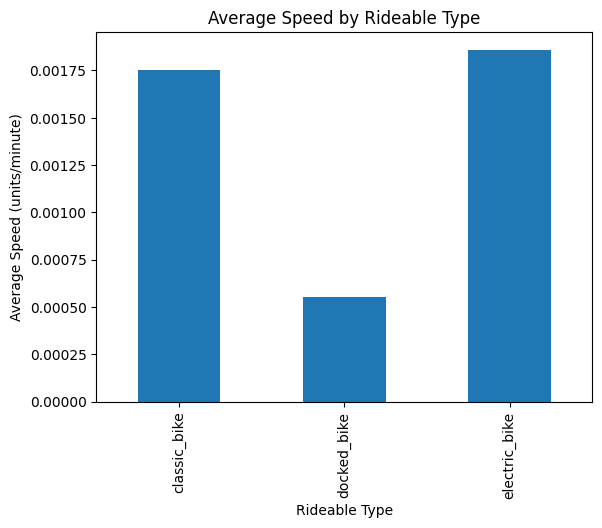

In [12]:
avg_speed_by_type = ddf.groupby('rideable_type')['speed'].mean().compute()
avg_speed_by_type.plot(kind='bar', title='Average Speed by Rideable Type')
plt.xlabel('Rideable Type')
plt.ylabel('Average Speed (units/minute)')
plt.show()

接下来我们使用`group_by()`对数据进行分组，并进行`count()`、`sort_values()`、`mean()`等操作对数据进行处理。

In [13]:
def process_data(df: dd.DataFrame):
    # 按起始站分组的总行程数
    total_rides_by_start_station = (
        df.groupby("start_station_name")["ride_id"].count().compute()
    )
    print("按起始站分组的总行程数:")
    print(total_rides_by_start_station.head())

    # 对起始站分组的数据进行排序
    sorted_trips_by_start_station = total_rides_by_start_station.sort_values(
        ascending=False
    )
    print("\n按总行程数降序排序的起始站:")
    print(sorted_trips_by_start_station.head())

    # 按月份和骑行类型分组的平均行程时长
    trip_duration_by_member_and_month = (
        df.groupby(["month", "rideable_type"])["trip_duration"].mean().compute()
    )
    print("\n按月份和骑行类型分组的平均行程时长:")
    print(trip_duration_by_member_and_month)

    return trip_duration_by_member_and_month


trip_duration_by_member_and_month = process_data(ddf)

按起始站分组的总行程数:
start_station_name
11 St & Washington St                4688
12 St & Sinatra Dr N                 3334
14 St Ferry - 14 St & Shipyard Ln    4100
4 St & Grand St                      2826
5 Corners Library                     938
Name: ride_id, dtype: int64

按总行程数降序排序的起始站:
start_station_name
Grove St PATH                                   12649
Hoboken Terminal - River St & Hudson Pl         12151
South Waterfront Walkway - Sinatra Dr & 1 St     8509
Hoboken Terminal - Hudson St & Hudson Pl         7281
City Hall - Washington St & 1 St                 6503
Name: ride_id, dtype: int64

按月份和骑行类型分组的平均行程时长:
month  rideable_type
1      classic_bike      10.560105
       docked_bike      134.876000
       electric_bike     15.283021
2      classic_bike       9.565480
       docked_bike      192.740067
       electric_bike     11.009021
3      classic_bike      10.081960
       docked_bike      105.768713
       electric_bike     12.169278
4      classic_bike      12.316335
      

下面我们对按月份和骑行类型分组的平均行程时长进行可视化。

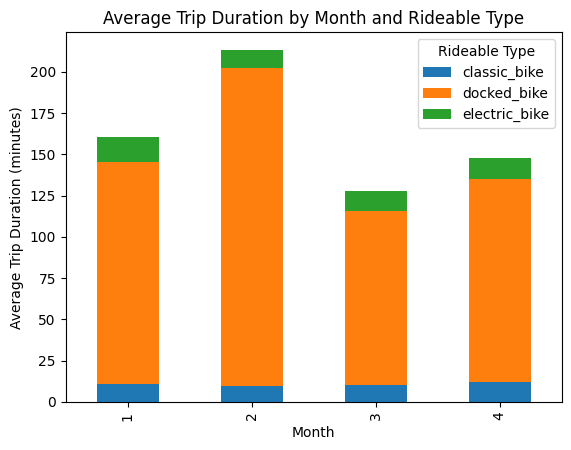

In [14]:
def plot_data(df):
    df.unstack().plot(kind="bar", stacked=True)
    plt.title("Average Trip Duration by Month and Rideable Type")
    plt.xlabel("Month")
    plt.ylabel("Average Trip Duration (minutes)")
    plt.legend(title="Rideable Type")
    plt.show()


plot_data(trip_duration_by_member_and_month)

我们再尝试加入新数据，使用`concat()`进行数据的合并和连接，并用相同的方法对合并后的数据进行处理。

In [15]:
from utils import more_citi_bike

bike_path2 = more_citi_bike()
ddf2: dd.DataFrame = dd.read_csv(os.path.join(bike_path2, "*.csv"))

ddf2 = ddf2.map_partitions(preprocess_data)

concatenated_ddf = dd.concat([ddf, ddf2], axis=0)

trip_duration_by_member_and_month2 = process_data(concatenated_ddf)

按起始站分组的总行程数:
start_station_name
11 St & Washington St                9190
12 St & Sinatra Dr N                 6934
14 St Ferry - 14 St & Shipyard Ln    7830
4 St & Grand St                      5703
5 Corners Library                    1745
Name: ride_id, dtype: int64

按总行程数降序排序的起始站:
start_station_name
Hoboken Terminal - River St & Hudson Pl         23356
Grove St PATH                                   23034
Hoboken Terminal - Hudson St & Hudson Pl        13792
South Waterfront Walkway - Sinatra Dr & 1 St    13727
City Hall - Washington St & 1 St                11791
Name: ride_id, dtype: int64

按月份和骑行类型分组的平均行程时长:
month  rideable_type
1      classic_bike      10.560105
       docked_bike      134.876000
       electric_bike     15.283021
2      classic_bike       9.565480
       docked_bike      192.740067
       electric_bike     11.009021
3      classic_bike      10.081960
       docked_bike      105.768713
       electric_bike     12.169278
4      classic_bike      12.316335
      

同样的进行可视化。

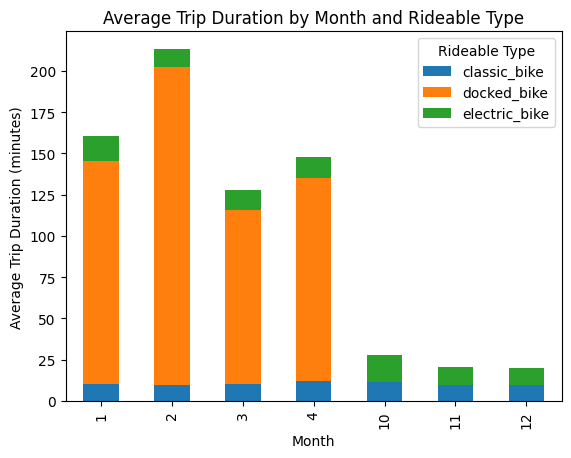

In [8]:
plot_data(trip_duration_by_member_and_month2)

最后尝试建立数据透视表以及数据的可视化。

数据透视表:
rideable_type                      classic_bike  docked_bike  electric_bike
start_station_name                                                         
11 Ave & W 27 St                      16.583333          NaN            NaN
11 St & Washington St                  9.993954    20.685897       9.397788
12 St & Sinatra Dr N                  14.230417    38.415351      13.857875
14 St Ferry - 14 St & Shipyard Ln     13.091936   198.055702      15.262149
2 Ave & E 29 St                        7.983333          NaN            NaN
...                                         ...          ...            ...
Warren St                             10.612448    52.636364      11.075977
Washington St                         12.518832   130.303125      11.796525
Washington St & Gansevoort St          3.750000          NaN            NaN
Willow Ave & 12 St                    10.836851    20.166667      11.164558
York St & Marin Blvd                  11.622333    54.966667      25.448760

[161

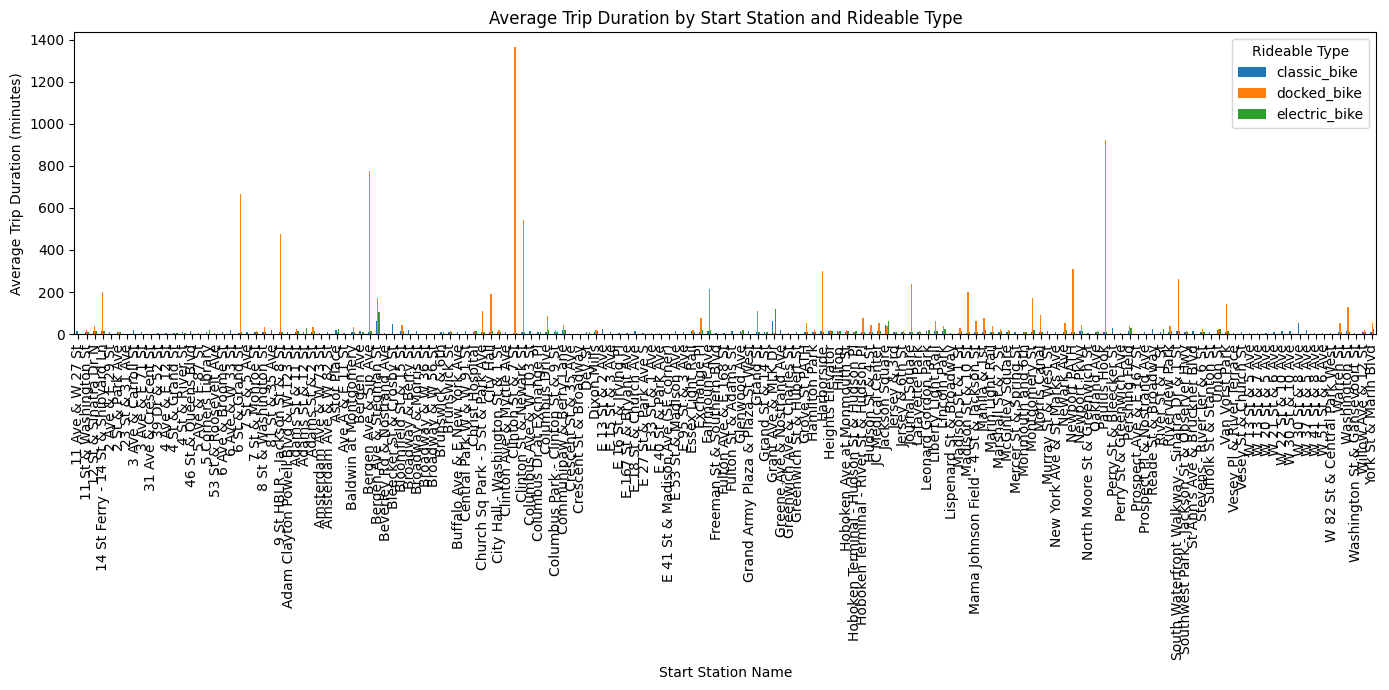

In [16]:
# 将'rideable_type'列转换为类别类型
concatenated_ddf["rideable_type"] = concatenated_ddf["rideable_type"].astype("category")
concatenated_ddf = concatenated_ddf.categorize(columns=["rideable_type"])

# 创建数据透视表
pivot_table = concatenated_ddf.pivot_table(
    index="start_station_name",
    columns="rideable_type",
    values="trip_duration",
    aggfunc="mean",
).compute()

print("数据透视表:")
print(pivot_table)

# 可视化数据透视表
pivot_table.plot(kind="bar", figsize=(14, 7))
plt.title("Average Trip Duration by Start Station and Rideable Type")
plt.xlabel("Start Station Name")
plt.ylabel("Average Trip Duration (minutes)")
plt.legend(title="Rideable Type")
plt.tight_layout()
plt.show()

注意不要忘记关闭集群和客户端

In [10]:
client.close()
cluster.close()

## 案例二：